In [7]:
import pandas as pd
from __future__ import division
from numbers import Number
import sys, codecs
import numpy as np
import sqlite3
import nltk

import matplotlib.pyplot as plt
%matplotlib inline

# Load data
There are 2 datasets I need:  
* **bgg_ratings_comments_full_r1.db**: SQL db storing all of the reviews for 2000+ games (along with username, rating, game name, and game id) for each review.  
* **bgg_gamelist.csv**: CSV file containing some meta-data for each of the games (one row per game). 

Ultimately I merge these two together and save it in a Dataframe called **df_allgames**.

In [9]:
def import_meta_gamelist(meta_gamelist_filename = 'bgg_gamelist.csv',
                        col_names = ['gameid', 'name', 'n_ratings', 'pic_url']):    
    """ 
    Import the Board Game Meta data from csv file.
    Input: 
        1. meta_gamelist_filename: file name of game list data with meta data (e.g., gameID, etc)
        2. col_names: what you want to name the columns of the dataset
    """

    df_meta_gamelist = pd.read_csv(meta_gamelist_filename) # Read in csv file with meta game info 
    df_meta_gamelist.columns = col_names # prettify column names
    
    return df_meta_gamelist


def import_reviews_from_db(db_filename = "bgg_ratings_comments_full_r1.db",
                          sql_query = "SELECT * FROM data WHERE value!='' AND rating>0"):
    """
    Import data from database file that contains review data (acquired from BGG API).
    Default sql_query extracts all non-empty reviews that contain a rating >0 (this
    eliminates a number of rows that have 0s across all columns)
    """
    connex = sqlite3.connect(df_filename)  # Opens DB file 
    cur = connex.cursor()  # Establish communication with DB 

    sql = sql_query + ";" # SQL query
    df_reviews_and_ratings = pd.read_sql_query(sql, connex) # Read DB data into 
    df_reviews_and_ratings = df_reviews_and_ratings.drop_duplicates() # Drop the duplicate rows

    connex.close() # close connection to db
    
    return df_reviews_and_ratings

def merge_meta_and_review_dfs(df_meta_gamelist, df_reviews_and_ratings):
    """
    Merge meta gamelist df together with reviews df.
    """
    # Merge game meta data with reviews
    df_merged = pd.merge(df_reviews_and_ratings, df_meta_gamelist, 
                               how='left', on='gameid')
    return df_merged

def import_and_merge_datasets(meta_gamelist_filename = 'bgg_gamelist.csv',
                              col_names = ['gameid', 'name', 'n_ratings', 'pic_url'],
                              db_filename = "bgg_ratings_comments_full_r1.db",
                              sql_query = "SELECT * FROM data WHERE value!='' AND rating>0"):
    """
    Implement all previous functions to import meta data and review data and merge
    them together. 
    """
    df_meta_gamelist = import_meta_gamelist(meta_gamelist_filename = 'bgg_gamelist.csv',
                                            col_names = ['gameid', 'name', 
                                                         'n_ratings', 'pic_url'])
    df_reviews_and_ratings = import_reviews_from_db(db_filename = "bgg_ratings_comments_full_r1.db",
                                                    sql_query = "SELECT * FROM data WHERE value!='' AND rating>0")
    df_merged = merge_meta_and_review_dfs(df_meta_gamelist=df_meta_gamelist, 
                                          df_reviews_and_ratings=df_reviews_and_ratings)
    
    return df_merged, df_meta_gamelist
    

In [10]:
# Pull review data from DB and merge with game meta data (df_allgames)
# Also returnt the df_meta_gamelist as bgg_gamelist
df_allgames, bgg_gamelist = import_and_merge_datasets(meta_gamelist_filename = 'bgg_gamelist.csv',
                              col_names = ['gameid', 'name', 'n_ratings', 'pic_url'],
                              db_filename = "bgg_ratings_comments_full_r1.db",
                              sql_query = "SELECT * FROM data WHERE value!='' AND rating>0")

In [11]:
df_allgames.head()

,gameid,username,rating,value,name,n_ratings,pic_url
0,13,sinahero,10.0,The best game in the world,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...
1,13,Cayden101,10.0,I've played this game probably close to a hund...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...
2,13,Spaceage Polymer,10.0,"I didn't want to give Catan a perfect ten, bec...",Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...
3,13,asauve19,10.0,My all time favorite game. Even if you are rol...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...
4,13,Feelie,10.0,One of (if not) the best board game. Ever chan...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...


# Text Cleaning: 
Remove board game names and Tokenize reviews

### Step 1: Make text in reviews all lowercase, and remove almost all board game names from reviews
Sometimes reviewers mention the board game names in reviews (e.g., "I first played *Splendor* with my friends in grad school."). I did not use any entity recognition techniques (like spacy), and therefore name dropping would only introduce noise into my average word vectors. To eliminate noise, I decided to filter (most of) the names out of the reviews. The exceptions included games that had names that can occur in other unrelated words (e.g., 'coup' is in the word 'couple'). 

In [12]:
import nltk

def cleaning1_lowercase_and_remove_bg_names(df_with_reviews = df_allgames,
                                            raw_review_col_name = 'value',
                                            df_gamelist = bgg_gamelist,
                                            game_name_col_df_gamelist = 'name'):
    """
    This function makes all text in reviews lowercase, and removes all
        board game names from review text (except for those on the 
        nameExclude_list - see below). 
    Input: All defaults
        Note: game_name_col_df_gamelist is the column within df_gamelist
        containing the names of the board games. 1 row per game in this df.
    Output: df_with_reviews df with a new column (rev_LC_noNames) 
        containing the reviews 
    """
    
    # Make a list with all the board game names 
    gameName_list = df_gamelist[game_name_col_df_gamelist].unique().tolist() 
    gameName_list = [game.lower() for game in gameName_list] # make lower case
    #print(len(gameName_list)) # debugging

    # Problem names: Names that appear too often in real words. 
    # Don't remove these from reviews. 
    nameExclude_list = ['ys', 'go', 'coup', 'ra', 'goa', 'set', 'pit', 
                        'fuse', 'roma', 'evo', 'aton', 'fits', 'frag', 
                        'pairs', 'rage', 'edo', 'war', 'tak']
    #[token for token in tokens if token not in en_stop]
    gameName_list = [game for game in gameName_list if game not in nameExclude_list]
    #print(len(gameName_list)) # debugging
    
    ##### Remove all board game names from the reviews. 

    ### Make reviews all lower case and replace game names with nothing
    # make raw reviews lowercase and save to new column named 'comments'
    # Note: this doesn't take long to run. 
    df_with_reviews['rev_LC_noNames'] = df_with_reviews[raw_review_col_name].apply(lambda x: x.lower()) 
    
    # Replace game names with ""
    # Note: This loop takes a while (because there are 2000+ games to loop through)
    for game in gameName_list:
        df_with_reviews['rev_LC_noNames'] = df_with_reviews['rev_LC_noNames'].apply(lambda x: x.replace(game, "")) 
    
    return df_with_reviews


def cleaning2_tokenize_words(df_with_reviews = df_allgames):
    '''
    Parse reviews into words. (Need to import nltk first.)
    Output: Adds a column (rev_cleaned) to df_with_reviews containing 
    tokenized reviews.
    '''

    ### Tokenize words in reviews: 
    df_with_reviews['rev_cleaned'] = df_with_reviews['rev_LC_noNames'].apply(lambda x: nltk.word_tokenize(x))
    
    return df_with_reviews


def cleaning3_remove_stopwords(df_with_reviews = df_allgames,
                              nonfeatures = ['star', 'nostar']):
    '''
    Cleaning Step 3. Remove stop words and words not likely to be features.
    Output: Modified rev_cleaned column within df_with_reviews.
    '''
    en_stop = set(nltk.corpus.stopwords.words('english')) # set stop words
    
    # updates set of stop words with the ones I wanted to add (i.e., 
    # very frequently used emoticons)
    en_stop.update(nonfeatures) 
    
    # Remove stop words:
    df_with_reviews['rev_cleaned'] = df_with_reviews['rev_cleaned'].apply(lambda review: [word for word in review if word not in en_stop])
    
    return df_with_reviews


In [13]:
### Function applies all cleaning steps to df.
def clean_reviews(df_with_reviews = df_allgames,
                  raw_review_col_name = 'value',
                  df_gamelist = bgg_gamelist,
                  game_name_col_df_gamelist = 'name',
                  nonfeatures = ['star', 'nostar']):
    """
    Applies all 3 cleaning steps to clean raw reviews in df_with_reviews. 
    Creates 2 new columns within df_with_reviews: 
        1. 'rev_LC_noNames': untokenized, lowercase reviews with board game
            names removed. This should be used later for Sentiment 
            Analysis and keyword search (if you're into that). 
        2. 'rev_cleaned': cleaned reviews (ready for Word2Vec).
    """
    import nltk
    
    # Run Step 1: Lowercase reviews and remove board game names.
    df_with_reviews = cleaning1_lowercase_and_remove_bg_names(df_with_reviews = df_with_reviews,
                                            raw_review_col_name = raw_review_col_name,
                                            df_gamelist = df_gamelist,
                                            game_name_col_df_gamelist = game_name_col_df_gamelist)
    # Run Step 2: Tokenize reviews into words.
    df_with_reviews = cleaning2_tokenize_words(df_with_reviews = df_with_reviews)

    # Apply Cleaning Step 3. Remove stop words. 
    df_with_reviews = cleaning3_remove_stopwords(df_with_reviews = df_with_reviews,
                                             nonfeatures = nonfeatures)
    return df_with_reviews


In [15]:
import nltk

# Clean reviews
df_allgames = clean_reviews(df_allgames)

# Threw error because nltk not defined. Need to figure out where to put 
# package dependencies in my function. It still ran the first step, 
# which is the one that takes the longest. Now just run the next 2 steps. 

# Until it is fixed: Just run steps 1 and 2. 
#df_allgames = cleaning2_tokenize_words(df_allgames)
#df_allgames = cleaning3_remove_stopwords(df_allgames)

df_allgames.head()

,gameid,username,rating,value,name,n_ratings,pic_url,rev_LC_noNames,rev_cleaned
0,13,sinahero,10.0,The best game in the world,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,the best game in the world,"[best, game, world]"
1,13,Cayden101,10.0,I've played this game probably close to a hund...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,i've played this game probably close to a hund...,"['ve, played, game, probably, close, hundred, ..."
2,13,Spaceage Polymer,10.0,"I didn't want to give Catan a perfect ten, bec...",Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,"i didn't want to give a perfect ten, because ...","[n't, want, give, perfect, ten, ,, 's, even, f..."
3,13,asauve19,10.0,My all time favorite game. Even if you are rol...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,my all time favorite game. even if you are rol...,"[time, favorite, game, ., even, rolling, bad, ..."
4,13,Feelie,10.0,One of (if not) the best board game. Ever chan...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,one of (if not) the best board game. ever chan...,"[one, (, ), best, board, game, ., ever, changi..."


In [16]:
#### Save Output! From text cleaning! Try pickle.dump

##### Pickle the dataframe:
#df_allgames.to_pickle('./bgg_ratings_comments_full_rev2vec.pkl')

import pickle

### Pickle dump: Test on 1000 rows first. 
#filename = 'pickle_test.pkl'
filename = 'bgg_ratings_reviews_full_posttextcleaning.pkl'
outfile = open(filename, 'wb')
pickle.dump(df_allgames, outfile)
outfile.close()


# Rev2Vec: Average Word2Vec vectors for each review  
#### Tools: Gensim and the Google News pretrained Word2Vec model  
  
**Word2Vec Model Selection:** I decided to use a pre-trained Word2Vec model (previously trained on text from Google News) because I was concerned I wouldn't have enough text within the reviews to create an accurate enough Word2Vec model capable of producing meaningful results. This was confirmed when I discussed my project with several people who were knowledgable about Word2Vec - they all recommended using a pre-trained model.  
  
**Approach:** For each review, I create an average vector that represents an average of all the Word2Vec vectors for each word contained in preprocessed version of review. This average vector is then saved in the *'rev2vec'* column in the dataframe. 

In [19]:
import pickle

## Pickle Load: 
filename = 'bgg_ratings_reviews_full_posttextcleaning.pkl'

infile = open(filename, 'rb')
df_allgames = pickle.load(infile)
infile.close()

df_allgames.head()

In [14]:
### Using the Google News pre-trained Word2Vec model to convert words 
# into vectors (with Gensim):

from gensim.models import KeyedVectors
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('/Users/meredithjohnson/Downloads/GoogleNews-vectors-negative300.bin', binary=True)


In [15]:
### Functions borrowed from Bart:

# Apply pre-trained word2vec model to a single word. 
def _evaluate(word):
        
    if(isinstance(word,list)):
        return __evaluate_set(word)
    elif(isinstance(word,str)):
        #attempt to get vectorial representation of word.
        try:
            return model[word]
        except KeyError as e:
            return np.full([300,],np.nan)
    else:
        raise TypeError()
            
# Apply the word2vec model to a set of words and average them. 
def __evaluate_set(words):
    #evaluate each word in 
    n = 0
    a = []
    for w in words:
        #attempt to evaluate vectorial representation of word.
        try:
            v = model[w]
            if((np.isnan(v).any() + np.isinf(v).any()) == 0):
                a.append(v)
                n += 1
        except KeyError as e:
            pass
    #if nothing was valid, return nan
    if(n==0):
        return np.full([300,], np.nan)
    #return average
    return np.mean(np.array(a),axis=0)

In [18]:
#### New Version: 

def add_rev2vec_column(df_with_reviews = df_allgames, 
                      cleaned_reviews_col_name = 'rev_cleaned'):
    """
    This function creates a mean vector for each review (contained in the 
    column named cleaned_reviews_col_namees within the df_with_reviews
    and outputs it in a matrix. 
    _evaluate is Bart's function that creates a mean word2vec
    vector for an entire set of words by averaging across the word vectors
    in the set.
    
    Then it adds each array containing the rev2vec to the df_with_reviews
    in a single column ('rev2vec'). 
    """
    rev2vecs = []
    
    # Iterate through each row of df_with_reviews and create a w2v vector
    # for each review. 
    for index, row in df_with_reviews.iterrows():
        review = row[cleaned_reviews_col_name]
        review_vec = _evaluate(review)
        #if ((np.isnan(review_vec).any() + np.isinf(review_vec).any()) == 0):
        rev2vecs.append(review_vec)
        
        # Store vectors for each review as an array in a single column:

    df_with_reviews['rev2vec'] = pd.Series(rev2vecs, index=df_with_reviews.index)

    return df_with_reviews
        
#### Note: 
# Future version of this script could let user pick whether they want the 
# w2vecs added to the df, or if they want just the list of them (i.e., 
# return rev2vecs instead). 

In [19]:
### Apply function:
df_allgames = add_rev2vec_column(df_allgames)

df_allgames.head()

,gameid,username,rating,value,name,nrate,pic_url,rev_LC_noNames,rev_cleaned,rev2vec
0,13,sinahero,10.0,The best game in the world,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,the best game in the world,"[best, game, world]","[-0.025390625, 0.0476888, 0.18489583, 0.096547..."
1,13,Cayden101,10.0,I've played this game probably close to a hund...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,i've played this game probably close to a hund...,"['ve, played, game, probably, close, hundred, ...","[0.013619995, 0.07537842, 0.034295656, 0.15359..."
2,13,Spaceage Polymer,10.0,"I didn't want to give Catan a perfect ten, bec...",Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,"i didn't want to give a perfect ten, because ...","[n't, want, give, perfect, ten, ,, 's, even, f...","[0.020022582, 0.037402343, 0.0032592774, 0.119..."
3,13,asauve19,10.0,My all time favorite game. Even if you are rol...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,my all time favorite game. even if you are rol...,"[time, favorite, game, ., even, rolling, bad, ...","[0.071272224, 0.087642275, 0.019033367, 0.1054..."
4,13,Feelie,10.0,One of (if not) the best board game. Ever chan...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,one of (if not) the best board game. ever chan...,"[one, (, ), best, board, game, ., ever, changi...","[-0.041544598, -0.03446452, -0.0030263264, 0.1..."


In [21]:
### Are there a lot of nas? 
#df_allgames[df_allgames['rev2vec'].isna()]
#if ((np.isnan(review_vec).any() + np.isinf(review_vec).any()) == 0):


In [27]:
##### Pickle the dataframe:
#df_allgames.to_pickle('./bgg_ratings_comments_full_rev2vec.pkl')

import pickle

### Pickle dump: Test on 1000 rows first. 
#filename = 'pickle_test.pkl'
filename = 'bgg_ratings_reviews_full_rev2v.pkl'
outfile = open(filename, 'wb')
pickle.dump(df_allgames, outfile)
outfile.close()

OSError: [Errno 22] Invalid argument

In [26]:
## Pickle Load: 
infile = open(filename, 'rb')
pickletoy_load = pickle.load(infile)
infile.close()
pickletoy_load.head()


,gameid,username,rating,value,name,nrate,pic_url,rev_LC_noNames,rev_cleaned,rev2vec
0,13,sinahero,10.0,The best game in the world,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,the best game in the world,"[best, game, world]","[-0.025390625, 0.0476888, 0.18489583, 0.096547..."
1,13,Cayden101,10.0,I've played this game probably close to a hund...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,i've played this game probably close to a hund...,"['ve, played, game, probably, close, hundred, ...","[0.013619995, 0.07537842, 0.034295656, 0.15359..."
2,13,Spaceage Polymer,10.0,"I didn't want to give Catan a perfect ten, bec...",Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,"i didn't want to give a perfect ten, because ...","[n't, want, give, perfect, ten, ,, 's, even, f...","[0.020022582, 0.037402343, 0.0032592774, 0.119..."
3,13,asauve19,10.0,My all time favorite game. Even if you are rol...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,my all time favorite game. even if you are rol...,"[time, favorite, game, ., even, rolling, bad, ...","[0.071272224, 0.087642275, 0.019033367, 0.1054..."
4,13,Feelie,10.0,One of (if not) the best board game. Ever chan...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,one of (if not) the best board game. ever chan...,"[one, (, ), best, board, game, ., ever, changi...","[-0.041544598, -0.03446452, -0.0030263264, 0.1..."


In [ ]:
# Actually this might have worked. produced 1+GB csv file...
#dftoy.to_csv('bgg_ratings_comments_full_w2v.csv', index=True)
# Only worked for like less than 25% of the reviews before it quit.  

In [147]:
#### Store this new dataframe in a sql database 
# for quick loading in future:

# import sqlite3
# connex = sqlite3.connect("bgg_ratings_comments_full_w2v.db")  
#     # Opens file if exists, else creates file
# cur = connex.cursor()  
#     # This object lets us actually send messages to our DB and receive results

# dftoy.to_sql(name="data", con=connex, if_exists="append", index=False)    

# # Save our changes and close the connection
# connex.commit()
# connex.close()

### See if it worked. 
# connex = sqlite3.connect("bgg_ratings_comments_toy.db")  # Opens file if exists, else creates file
# cur = connex.cursor()  # This object lets us actually send messages to our DB and receive results
# sql = "SELECT * FROM data" + ";"
# df_ratings = pd.read_sql_query(sql, connex)
# print(df_ratings.shape)
# df_ratings.sample(n=10)

InterfaceError: Error binding parameter 8 - probably unsupported type.

In [97]:
# m_rev2vec = df_rev2vec # save the matrix version 
# df_rev2vec = pd.DataFrame(df_rev2vec) # create dataframe version
# df_rev2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,960,961,962,963,964,965,966,967,968,969
0,0.012540,0.080758,0.000366,0.027981,0.051949,-0.058146,0.029157,0.009981,0.106934,0.038890,...,0.122144,0.069026,0.011449,0.095712,0.035170,0.018248,0.066904,0.034058,0.060566,0.097495
1,0.001863,-0.010102,0.145574,0.008885,0.051065,0.130452,0.037863,0.043328,-0.105469,0.093411,...,0.077075,0.009033,0.067105,-0.018175,0.021218,0.040872,0.074795,-0.034470,0.010009,0.080606
2,-0.031505,-0.034616,0.116561,-0.022850,-0.019334,0.082896,-0.010336,0.003535,0.053223,0.009772,...,-0.136914,0.011658,0.014171,0.011688,0.000444,0.011827,-0.026077,-0.095459,-0.011869,-0.033386
3,0.074724,0.085602,0.066789,0.114505,0.086765,0.064407,0.076738,0.048779,0.069824,0.090451,...,0.222968,0.062117,0.170437,0.063506,0.113399,0.125427,0.091571,-0.044434,0.096558,0.086496
4,-0.033142,-0.032680,-0.054599,-0.082543,-0.029896,0.019246,-0.043105,-0.090468,-0.073242,0.042841,...,0.079773,0.071737,0.019548,0.003697,-0.054256,-0.013988,-0.010602,-0.070068,-0.076219,-0.062696


# Skip down below. This is playing around with cut-off. Pull nearest comments to a selected topic

In [24]:
# define feature of interest ("FOI")
foi = 'kids'
gameSelect = 'splendor'

In [ ]:
#cosine similarity

#cosine_similarity = numpy.dot(model['spain'], model['france'])/(numpy.linalg.norm(model['spain'])* numpy.linalg.norm(model['france']))

In [39]:
### More code borrowed from Bart!! 

import scipy

w2vs = [v for v in dftoy['rev2vec'].get_values()]

comparator = scipy.spatial.distance.cosine

#compares word vectors to eachother using comparator function.
#Comparator function is cosine distance by default.
def __compare(u):
    #return distances between vector and all our podcasts.
    return np.array([comparator(u,v) for v in w2vs])

In [40]:
#primary search method. finds podcasts most similar to some input words
def search_revs_for_feature(word,n_outputs=5,verbose=False):

    #word = cleaner.preprocess_input(word)

    transformed_word = _evaluate(word)

    if(verbose):
        print('Input transformed')

    #Find most similar reviews, and include a similarity metric.
    output = dftoy.iloc[__compare(transformed_word).argsort()[:n_outputs]]
    if(verbose):
        print('Compared to database')
    output['similarity'] = [comparator(transformed_word,v) for v in output['rev2vec'].get_values()]
    if(verbose):
        print('output returned')
    return output
    #return [self.podcastdb.loc[self.podcastdb['collectionId']==thisid] for thisid in bestID]


#primary method. finds podcasts most similar to some word, and crawls their RSS feeds to find most similar episodes.
# def search_episodes(word,n_outputs=3,n_episodes=5,n_most_recent=10,verbose=False):

#     #find the best podcasts, evaluate input
#     pc_match = search(word,n_outputs,verbose=verbose)
#     if(verbose):
#         print('Evaluate input again')
#     u = self._evaluate(self.cleaner.preprocess_input(word,rep_dash=True))

#     if(verbose):
#         print('Getting episodes')
#     #get the episodes associated with the best podcasts
#     ep_data = [self._get_eps(pc_match.iloc[i]['feedUrl']) for i in range(0,len(pc_match))] 
#     if(verbose):
#         print('Episodes obtained. cleaning...')
#     #vectorize each episode
#     ep_vec = [[self._evaluate(self.cleaner.preprocess_input(eps['entries'][i]['content'][0]['value'])) 
#                for i in range(0,min([n_most_recent,len(eps['entries'])]))] for eps in ep_data]
#     #Get the closest matching eps.
#     sorted_eps = [np.array([self.comparator(u,v) for v in ev]).argsort()[:n_outputs] for ev in ep_vec]
#     if(verbose):
#         print('Episodes cleaned.')

#     #return the data for the best eps
#     return pc_match, [[ep_data[i]['entries'][j] for j in sorted_eps[i]]
#                       for i in range(0,len(ep_data))]

In [56]:
dftest_kids = search(foi,1500)
dftest_kids.head(20)

### Note to myself: lower similarity values mean they are closer together!

/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gameid,username,rating,value,name,nrate,pic_url,comments,comm_Words,comm_WNostops,rev2vec,similarity
1463062,8924,scottie771,8.0,Best kid's game that I have in my collection. ...,Dancing Eggs,1897,https://cf.geekdo-images.com/micro/img/xrC7Py1...,best kid's game that i have in my collection. ...,"[best, kid, 's, game, that, i, have, in, my, c...","[best, kid, 's, game, collection, ., played, k...","[0.063802086, 0.045925565, -0.015462239, 0.191...",0.229090
1373089,3570,chainsaw_ash,8.0,KIDS GAME for children under 8 I'd say. Great ...,Chicken Cha Cha Cha,2353,https://cf.geekdo-images.com/micro/img/tC2QeuX...,kids game for children under 8 i'd say. great ...,"[kids, game, for, children, under, 8, i, 'd, s...","[kids, game, children, 8, 'd, say, ., great, g...","[0.066603996, 0.00097225024, -0.010872219, 0.1...",0.255718
995683,91514,mattramsey,5.0,Great kids game!,Rhino Hero,5204,https://cf.geekdo-images.com/micro/img/4BaQQQv...,great kids game!,"[great, kids, game, !]","[great, kids, game, !]","[0.05753581, 0.1011556, -0.032104492, 0.182159...",0.260356
1386566,3570,ghostofmerlin,6.0,Great kids' memory game. We have a lot of fun...,Chicken Cha Cha Cha,2353,https://cf.geekdo-images.com/micro/img/tC2QeuX...,great kids' game. we have a lot of fun with ...,"[great, kids, ', game, ., we, have, a, lot, of...","[great, kids, ', game, ., lot, fun, ., 's, int...","[0.034960065, 0.044566564, -0.12006487, 0.1614...",0.291743
1800883,4209,efreeman,4.0,"Rated as an adult. solid kids game, with some...",Monza,1171,https://cf.geekdo-images.com/micro/img/pUHiEhL...,"rated as an adult. solid kids game, with some...","[rated, as, an, adult, ., solid, kids, game, ,...","[rated, adult, ., solid, kids, game, ,, decisi...","[-0.013164793, 0.06657191, -0.06233869, 0.0775...",0.294987
178853,65244,VolleyGame,6.0,"1.7 - Not bad. Fun for kids, but a too simple ...",Forbidden Island,31752,https://cf.geekdo-images.com/micro/img/0sLYluE...,"1.7 - not bad. fun for kids, but a too simple ...","[1.7, -, not, bad, ., fun, for, kids, ,, but, ...","[1.7, -, bad, ., fun, kids, ,, simple, .]","[0.10870361, -0.007019043, -0.036071777, 0.185...",0.302212
1449458,17053,hemtozi,6.5,Played this with a few of my younger cousins. ...,Sleeping Queens,2014,https://cf.geekdo-images.com/micro/img/apaH3JG...,played this with a few of my younger cousins. ...,"[played, this, with, a, few, of, my, younger, ...","[played, younger, cousins, ., quite, fun, fami...","[0.01940918, 0.03676758, -0.012133789, 0.11833...",0.336883
1310294,6351,rarbelaez,6.5,Nice game for kids 2 1/2 and over. I've played...,Gulo Gulo,2645,https://cf.geekdo-images.com/micro/img/9JqXY5R...,nice game for kids 2 1/2 and over. i've played...,"[nice, game, for, kids, 2, 1/2, and, over, ., ...","[nice, game, kids, 2, 1/2, ., 've, played, muc...","[0.05505371, 0.058736164, -0.074100494, 0.1868...",0.337150
1491899,5895,Jimzik,4.0,My kids loved this game until it broke.,Hungry Hungry Hippos,1822,https://cf.geekdo-images.com/micro/img/VyhGvXp...,my kids loved this game until it broke.,"[my, kids, loved, this, game, until, it, broke...","[kids, loved, game, broke, .]","[0.058898926, 0.02520752, 0.012329102, 0.12941...",0.354898
1306996,6351,alkaiser,7.0,[Childrens Game] Very fun game that my 10 and ...,Gulo Gulo,2645,https://cf.geekdo-images.com/micro/img/9JqXY5R...,[childrens game] very fun game that my 10 and ...,"[[, childrens, game, ], very, fun, game, that,...","[[, childrens, game, ], fun, game, 10, 8, year...","[0.06826864, 0.009337471, -0.043182008, 0.0780...",0.357931


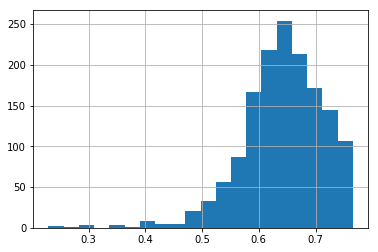

In [58]:
dftest_kids['similarity'].hist(bins=20)

In [57]:
## this suggests maybe a cut-off around 5.75?? Or something? 

dftest_kids = dftest_kids.sort_values(by='similarity', ascending=False)
dftest_kids.head(30)

,gameid,username,rating,value,name,nrate,pic_url,comments,comm_Words,comm_WNostops,rev2vec,similarity
1716502,95683,TyrionXavier,9.2,Much improved over the original. My favourite...,Arkham Horror: The Curse of the Dark Pharaoh E...,1073,https://cf.geekdo-images.com/micro/img/3FGhrO8...,much improved over the original. my favourite...,"[much, improved, over, the, original, ., my, f...","[much, improved, original, ., favourite, small...","[0.01663547, 0.07697211, -0.03753662, 0.108940...",0.765727
1805576,25491,rossum,4.0,WAY too long with six. I might revise my opini...,Alhambra: The Dice Game,995,https://cf.geekdo-images.com/micro/img/rbH7OyO...,way too long with six. i might revise my opini...,"[way, too, long, with, six, ., i, might, revis...","[way, long, six, ., might, revise, opinion, pl...","[-0.0016326904, -0.027252197, 0.016204834, 0.1...",0.765455
1693263,1662,teaticket,9.0,Great block game on the Waterloo campaign.,"Napoleon: The Waterloo Campaign, 1815",1132,https://cf.geekdo-images.com/micro/img/yvQiCVE...,great block game on the waterloo campaign.,"[great, block, game, on, the, waterloo, campai...","[great, block, game, waterloo, campaign, .]","[0.08828125, 0.07060547, 0.04018555, 0.0438659...",0.765312
1670598,3139,Solamar,7.2,"BestWith:2,4>3_not5. Some say best with 3, sin...",Goldland,1207,https://cf.geekdo-images.com/micro/img/p8Lij2z...,"bestwith:2,4>3_not5. some say best with 3, sin...","[bestwith:2,4, >, 3_not5, ., some, say, best, ...","[bestwith:2,4, >, 3_not5, ., say, best, 3, ,, ...","[-0.0039248997, 0.020284018, 0.03540378, 0.062...",0.765146
1355403,5206,Dior,8.0,A great classic!,Ogre,2411,https://cf.geekdo-images.com/micro/img/SoyKA7S...,a great classic!,"[a, great, classic, !]","[great, classic, !]","[0.18041992, 0.13891602, 0.066833496, 0.234863...",0.764808
851812,22827,vishallan,8.0,Awesome Gameplay. Intense and Quick. Brings th...,StarCraft: The Board Game,6450,https://cf.geekdo-images.com/micro/img/Qa7aKEj...,awesome gameplay. intense and quick. brings th...,"[awesome, gameplay, ., intense, and, quick, .,...","[awesome, gameplay, ., intense, quick, ., brin...","[0.12158203, -0.026339443, -0.049138848, 0.057...",0.764307
699042,21348,BaSL,8.5,"Nice variant, but a little too fiddly",Ticket to Ride: Märklin,8105,https://cf.geekdo-images.com/micro/img/q2ZzPAJ...,"nice variant, but a little too fiddly","[nice, variant, ,, but, a, little, too, fiddly]","[nice, variant, ,, little, fiddly]","[0.2121582, 0.064086914, -0.1262207, 0.3164062...",0.764004
323857,123260,mickwood,8.0,iPad and physical versions. 1-4 players. Vario...,Suburbia,17372,https://cf.geekdo-images.com/micro/img/ItLTGgZ...,ipad and physical versions. 1-4 players. vario...,"[ipad, and, physical, versions, ., 1-4, player...","[ipad, physical, versions, ., 1-4, players, .,...","[-0.024993896, 0.019607544, -0.07335663, 0.170...",0.763439
523487,83330,andreasrem1980,10.0,My favorite board game this one and mansions o...,Mansions of Madness,11464,https://cf.geekdo-images.com/micro/img/_yLHu4Z...,my favorite board game this one and 2nd editi...,"[my, favorite, board, game, this, one, and, 2n...","[favorite, board, game, one, 2nd, edition, dif...","[0.05340576, -0.0067596436, 0.019012451, 0.079...",0.762899
1739197,180592,Renno,8.07,Need to try,Steam Time,1013,https://cf.geekdo-images.com/micro/img/HIAHv8w...,need to try,"[need, to, try]","[need, try]","[0.12374878, 0.1508789, 0.05102539, 0.12365723...",0.762777


In [61]:
dftest_midsim = dftest_kids[dftest_kids['similarity']>.55]
dftest_midsim = dftest_midsim[dftest_midsim['similarity']<.7]
dftest_midsim.shape

(1036, 12)

In [62]:
dftest_midsim.to_csv('SimilarityCutoffTesting_kids.csv', index=True)

## Validation Sample
500 reviews from Catan (randomly selected)

In [142]:
df_validation = df_allgames[df_allgames['name']=='Catan']
#df_validation.head()

In [143]:
df_validation = df_validation.drop(columns=['gameid', 'nrate', 'pic_url', 'comments', 
                                            'comm_Words', 'comm_WNostops', 'rev2vec'])
df_validation.head()

,username,rating,value,name
0,sinahero,10.0,The best game in the world,Catan
1,Cayden101,10.0,I've played this game probably close to a hund...,Catan
2,Spaceage Polymer,10.0,"I didn't want to give Catan a perfect ten, bec...",Catan
3,asauve19,10.0,My all time favorite game. Even if you are rol...,Catan
4,Feelie,10.0,One of (if not) the best board game. Ever chan...,Catan


In [144]:
print(df_validation.shape)
df_validation = df_validation.sample(500)
print(df_validation.shape)

(13046, 4)
(500, 4)


In [145]:
# Save to csv file:
df_validation.to_csv('Validation_Data_Catan_500.csv', index=True)


# MVP (round 3)

**Input:**  
* Game  
* Search term(s) (Future: limit possible search terms maybe?)  

**Output:**   
* 10 most similar reviews (in future: it'd be nice to output like 5 positive and 5 negative review exemplars)  
* Sentiment analysis of most similar reviews within cut-off (Future: at the sentence level instead of review)  

In [96]:
### Input: 

featureSearch = "strategy"
gameSearch = "Catan"

In [97]:
### Pull Game Reviews

df_gameSearch = dftoy[dftoy['name']==gameSearch]
df_gameSearch.shape

(13046, 11)

In [146]:
### More code borrowed from Bart!! 

import scipy

w2vs = [v for v in df_gameSearch['rev2vec'].get_values()]

comparator = scipy.spatial.distance.cosine

#compares word vectors to eachother using comparator function.
#Comparator function is cosine distance by default.
def __compare(u):
    #return distances between vector and all our podcasts.
    return np.array([comparator(u,v) for v in w2vs])

#primary search method. finds podcasts most similar to some input words
def search_revs_for_feature(word,n_outputs=5,verbose=False):

    transformed_word = _evaluate(word)

    if(verbose):
        print('Input transformed')

    #Find most similar reviews, and include a similarity metric.
    output = df_gameSearch.iloc[__compare(transformed_word).argsort()[:n_outputs]]
    if(verbose):
        print('Compared to database')
    output['similarity'] = [comparator(transformed_word,v) for v in output['rev2vec'].get_values()]
    if(verbose):
        print('output returned')
    return output

### Output 1: Top 10 Most Relevant Reviews

In [99]:
### Return 10 Most Relevant Reviews: 

# Top10Revs = search_revs_for_feature(featureSearch,10).value
# Top10Revs

/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


72217                                              strategy
246911       3-4 90min - family, strategy - Würfel, network
264093                         Luck with a mix of strategy.
173814                  Strategy, resource management game.
262221    this is my first board game. classic strategy ...
263616    A classic gateway, but too much luck that cann...
249768    Some trading strategy makes this fun, but defi...
82918                              Wonderful strategy game.
24675            Classic family game with some strategy.   
31460     My gateway game that has some of the best bala...
Name: value, dtype: object

In [101]:
Top10Revs.values

array(['strategy', '3-4 90min - family, strategy - Würfel, network',
       'Luck with a mix of strategy.',
       'Strategy, resource management game.',
       'this is my first board game. classic strategy board game.simply play ,more strategy,medium luck factor..',
       'A classic gateway, but too much luck that cannot be nullified by strategy and tactics.',
       'Some trading strategy makes this fun, but definitely Catan: Cities and Knights is way better for more victory point conditions and strategy.',
       'Wonderful strategy game.',
       'Classic family game with some strategy.   ',
       'My gateway game that has some of the best balanced strategy.'],
      dtype=object)

In [124]:
def make_df_revSimilarity(gameName,feature,cutoff=.3,nTopRevs=10): 
    """"
    # Function 1: This function returns 2 things: 
        1. TopRevs: list with the most similar nTopRevs 
        2. df_featureSearch: Dataframe with reviews that fall within similarity 
                cut-off for specified game and feature
    # Input: 
        1. gameName: the name of the game. Must match name in df_allgames. 
        2. feature: search term of interest
        3. Set cut-off: (i.e., if .2, then add .2 to the minimum distance)
        4. nTopRevs: number of reviews to extract as exemplars (most similar to feature)
    """
    
    ### Extract reviews within the similarity cut-off: 
    # (2000 is max number of reviews to pull (for now))
    df_featureSearch = search_revs_for_feature(featureSearch,2000)
    
    # Return top 10 
    TopRevs = df_featureSearch.head(nTopRevs)
    
    # Calculate the cosine similarity distance maximum cut-off boundary.
    distMin = min(df_featureSearch['similarity'])
    cutOffBoundary = distMin + cutOff
    df_featureSearch = df_featureSearch[df_featureSearch['similarity']<cutOffBoundary]
    
    return TopRevs, df_featureSearch

In [126]:
# Apply function
TopRevs, df_featureSearch = make_df_revSimilarity(gameSearch,featureSearch)


/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Sentiment Analysis of Reviews
Reviews within certain cut-off of cosine similarity distance from input word/phrase are analyzed for sentiment using TextBlob. 

In [133]:
from textblob import TextBlob

def add_sentiment_cols(df,reviewCol,sentColName,sentBinColName): 
    """
    ## Function that adds sentiment polarity columns to input df
        1. df: input dataframe
        2. reviewCol: Column containing the reviews (with board game names removed)
        3. sentColName: name to give your output column containing sentiment polarity
        4. sentBinColName: name to give binary sentiment polarity assignment column
    """

    # Sentiment analysis: Evaluate overall review sentiment: 
    df[sentColName] = df.apply(lambda row: TextBlob(row[reviewCol]).polarity, axis=1)
    
    # Assign to binary polarity category in a new column named sentBinColName: 
    df.loc[df[sentColName] > 0, sentBinColName] = 'Positive'
    df.loc[df[sentColName] < 0, sentBinColName] = 'Negative'
    
    return df

In [135]:
# Apply function to df: 
df_featureSearch = add_sentiment_cols(df_featureSearch,'comments','RevSentiment_Polar','RevSentiment_Polar_Bin')



In [93]:
# Sentiment Analysis: 

### Set cut-off: (i.e., if .2, then add .2 to the minimum distance)
# cutOff = .3

# ### first extract reviews within the similarity cut-off: 
# # (2000 is max number of reviews to pull (for now))
# df_featureSearch = search(featureSearch,2000)
# distMin = min(df_featureSearch['similarity'])
# cutOffBoundary = distMin + cutOff
# df_featureSearch = df_featureSearch[df_featureSearch['similarity']<cutOffBoundary]
# df_featureSearch.shape

/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(306, 12)

In [94]:
from textblob import TextBlob

# # Evaluate overall review sentiment: 
# df_featureSearch['RevSentiment_Polar'] = df_featureSearch.apply(lambda row: TextBlob(row['comments']).sentiment.polarity, axis=1)

        
# # Assign to binary polarity category: 
# df_featureSearch.loc[df_featureSearch['RevSentiment_Polar'] > 0, 
#                     'RevSentiment_Polar_Bin'] = 'Positive'
# df_featureSearch.loc[df_featureSearch['RevSentiment_Polar'] < 0, 
#                     'RevSentiment_Polar_Bin'] = 'Negative'
    
# df_featureSearch.head()
## Creating a dataframe with a count of the polarity values
# df_polar_cnt = df_word['RevSentiment_Polar_Bin'].value_counts(dropna=True) #temp df
    
#     # Merge with non-temp df that will contain all the words: 
#     df_polar = pd.merge(df_polar, 
#                         df_polar_cnt.rename_axis('SentimentPol').reset_index(name=word),
#                         how='left',
#                         on='SentimentPol')

# df_polar

#df_word = df_game[df_game['stemmed'].str.contains('simple')] # extract sentences with word

# Evaluate overall review sentiment: 

# df_allgames['comm_Sent'] = df_allgames.apply(lambda row: nltk.sent_tokenize(row['value']), axis=1)

# for sentence in df_word['comm_tknSent'][6023]:
#     print(TextBlob(sentence).sentiment)


# #categories_count = pd.melt(categories_count, value_name = 'category_n')
# df_polar.index = ['Positive', 'Negative']
# df_polar = df_polar.drop(['SentimentPol'], axis=1)
# df_polar

# df_polar_mrg = df_polar.T
# df_polar_mrg

,gameid,username,rating,value,name,nrate,pic_url,comments,comm_Words,comm_WNostops,rev2vec,similarity,RevSentiment_Polar,RevSentiment_Polar_Bin
262816,13,bazzer52,7.0,Great with kids good with adults,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,great with kids good with adults,"[great, with, kids, good, with, adults]","[great, kids, good, adults]","[0.06878662, 0.0289917, -0.10559082, 0.2020263...",0.212868,0.750000,Positive
205473,13,cktenhoff,8.0,Family - Kids Older,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,family - kids older,"[family, -, kids, older]","[family, -, kids, older]","[0.0077311196, -0.03849284, -0.09920248, 0.186...",0.224885,0.166667,Positive
138324,13,DJevelekova,8.0,Office Kids,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,office kids,"[office, kids]","[office, kids]","[-0.0357666, -0.049438477, -0.15454102, 0.0937...",0.229700,0.000000,NaN
271398,13,Hatepig,6.0,A good game for the kids.,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,a good game for the kids.,"[a, good, game, for, the, kids, .]","[good, game, kids, .]","[0.04711914, 0.052652996, -0.028442383, 0.1487...",0.268488,0.150000,Positive
187743,13,RBundy13,8.0,big hit with kids,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,big hit with kids,"[big, hit, with, kids]","[big, hit, kids]","[0.0871582, 0.044759113, -0.053792316, 0.21305...",0.311252,0.000000,NaN


In [95]:
#### Get proportions of positive and negative: 

## Create a dataframe with a count of the polarity values
df_polar_cnt = df_featureSearch['RevSentiment_Polar_Bin'].value_counts(dropna=True) 

df_polar_cnt = pd.DataFrame(df_polar_cnt).T

df_polar_cnt['Proportion_Positive'] = df_polar_cnt['Positive']/(df_polar_cnt['Positive']+df_polar_cnt['Negative'])
df_polar_cnt['Proportion_Negative'] = df_polar_cnt['Negative']/(df_polar_cnt['Positive']+df_polar_cnt['Negative'])

df_polar_cnt

,Positive,Negative,Proportion_Positive,Proportion_Negative
RevSentiment_Polar_Bin,261,34,0.884746,0.115254


In [111]:
df_featureSearch[df_featureSearch['RevSentiment_Polar']>0].sort_values('RevSentiment_Polar')['comments'].values[::-1]



array(['great fun! one of our favorits if we play in groups (with not-all-day- gamers)!!!',
       'great with kids good with adults',
       ' that started us into gaming.  we always loved games, but this got us into eurostyle.',
       'my wife, kids (21,18, & 13), and i all enjoy it every play. win or lose we have a good time.',
       'good for kids. i like playing with my family, but i don&#039;t think its great fun with hard-core competitors.',
       'everyone should own this, just to teach the family',
       ' that got my wife and parents into "my kind of gaming"... ',
       'played; parents own.',
       "kids love it, so i play it. kids love trading for stuff. it's good, not as good as i thought it would be. ",
       'alway good fun,  much loved by my mum',
       'great fun for family and friends.',
       "a great way to introduce people to the hobby.  plus, it's fun.",
       '. nothing best. really  is always great. my family and friends loves this, they want to play a

In [123]:
print('The rating score for reviews about family playability is:')
print(df_featureSearch['rating'].astype(float).mean())
print(' ')
print('The rating score for reviews:')
print(df_allgames[df_allgames['name']=='Catan']['rating'].astype(float).mean())

The rating score for reviews about family playability is:
7.476633986928104
 
The rating score for reviews:
7.1570668779702595


# MVP (round 3)

**Input:**  
* Game  
* Search term(s) (Future: limit possible search terms maybe?)  

**Output:**   
* 10 most similar reviews (in future: it'd be nice to output like 5 positive and 5 negative review exemplars)  
* Sentiment analysis of most similar reviews within cut-off (Future: at the sentence level instead of review)  

In [447]:
### Input: 

featureSearch = "player interaction"
gameSearch = "Splendor"

In [448]:
### Pull Game Reviews

df_gameSearch = dftoy[dftoy['name']==gameSearch]
df_gameSearch.shape

(4771, 11)

In [449]:
### More code borrowed from Bart!! 

import scipy

w2vs = [v for v in df_gameSearch['rev2vec'].get_values()]

comparator = scipy.spatial.distance.cosine

#compares word vectors to eachother using comparator function.
#Comparator function is cosine distance by default.
def __compare(u):
    #return distances between vector and all our podcasts.
    return np.array([comparator(u,v) for v in w2vs])

#primary search method. finds podcasts most similar to some input words
def search_revs_for_feature(word,n_outputs=5,verbose=False):

    transformed_word = _evaluate(word)

    if(verbose):
        print('Input transformed')

    #Find most similar reviews, and include a similarity metric.
    output = df_gameSearch.iloc[__compare(transformed_word).argsort()[:n_outputs]]
    if(verbose):
        print('Compared to database')
    output['similarity'] = [comparator(transformed_word,v) for v in output['rev2vec'].get_values()]
    if(verbose):
        print('output returned')
    return output

### Output 1: Top 10 Most Relevant Reviews

In [450]:
### Return 10 Most Relevant Reviews: 

# Top10Revs = search_revs_for_feature(featureSearch,10).value
# Top10Revs

In [101]:
Top10Revs.values

array(['strategy', '3-4 90min - family, strategy - Würfel, network',
       'Luck with a mix of strategy.',
       'Strategy, resource management game.',
       'this is my first board game. classic strategy board game.simply play ,more strategy,medium luck factor..',
       'A classic gateway, but too much luck that cannot be nullified by strategy and tactics.',
       'Some trading strategy makes this fun, but definitely Catan: Cities and Knights is way better for more victory point conditions and strategy.',
       'Wonderful strategy game.',
       'Classic family game with some strategy.   ',
       'My gateway game that has some of the best balanced strategy.'],
      dtype=object)

In [451]:
def make_df_revSimilarity(gameName,feature,cutoff=.3,nTopRevs=10): 
    """"
    # Function 1: This function returns 2 things: 
        1. TopRevs: list with the most similar nTopRevs 
        2. df_featureSearch: Dataframe with reviews that fall within similarity 
                cut-off for specified game and feature
    # Input: 
        1. gameName: the name of the game. Must match name in df_allgames. 
        2. feature: search term of interest
        3. Set cut-off: (i.e., if .2, then add .2 to the minimum distance)
        4. nTopRevs: number of reviews to extract as exemplars (most similar to feature)
    """
    
    ### Extract reviews within the similarity cut-off: 
    # (2000 is max number of reviews to pull (for now))
    df_featureSearch = search_revs_for_feature(featureSearch,2000)
    
    # Return top 10 
    TopRevs = df_featureSearch.head(nTopRevs)
    
    # Calculate the cosine similarity distance maximum cut-off boundary.
    distMin = min(df_featureSearch['similarity'])
    cutOffBoundary = distMin + cutOff
    df_featureSearch = df_featureSearch[df_featureSearch['similarity']<cutOffBoundary]
    
    return TopRevs, df_featureSearch

In [452]:
# Apply function
TopRevs, df_featureSearch = make_df_revSimilarity(gameSearch,featureSearch)


/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### Sentiment Analysis of Reviews
Reviews within certain cut-off of cosine similarity distance from input word/phrase are analyzed for sentiment using TextBlob. 

In [133]:
from textblob import TextBlob

def add_sentiment_cols(df,reviewCol,sentColName,sentBinColName): 
    """
    ## Function that adds sentiment polarity columns to input df
        1. df: input dataframe
        2. reviewCol: Column containing the reviews (with board game names removed)
        3. sentColName: name to give your output column containing sentiment polarity
        4. sentBinColName: name to give binary sentiment polarity assignment column
    """

    # Sentiment analysis: Evaluate overall review sentiment: 
    df[sentColName] = df.apply(lambda row: TextBlob(row[reviewCol]).polarity, axis=1)
    
    # Assign to binary polarity category in a new column named sentBinColName: 
    df.loc[df[sentColName] > 0, sentBinColName] = 'Positive'
    df.loc[df[sentColName] < 0, sentBinColName] = 'Negative'
    
    return df

In [454]:
# Apply function to df: 
df_featureSearch = add_sentiment_cols(df_featureSearch,'comments','RevSentiment_Polar','RevSentiment_Polar_Bin')


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [453]:
df_featureSearch[df_featureSearch['RevSentiment_Polar']>0].sort_values('RevSentiment_Polar')['comments'].values[::-1]





KeyError: 'RevSentiment_Polar'

# Model Validation

**Input:**  
* Game  
* Search term(s) (Future: limit possible search terms maybe?)  

**Output:**   
* 10 most similar reviews (in future: it'd be nice to output like 5 positive and 5 negative review exemplars)  
* Sentiment analysis of most similar reviews within cut-off (Future: at the sentence level instead of review)  

In [28]:
### Import Hand-Labeled validation data set:
df_valid = pd.read_csv('InsightProject_Validation_HandLabeling_TL.csv',
                      index_col='index_id', encoding = "utf-8")
df_valid.describe()

,none,luck_random_ctrl_dice,classic,family_kids,extensions_etc,simple,rules_easy_to_learn_teach,gateway_non_gamer_intro,strategy,player_interaction,replayability,timespent_pace_downtime_waiting,art_design,oldnews_hype_burnout,setup,abstraction,mechanics,quality_physical
count,117.000000,95.000000,75.0,31.000000,65.000000,29.000000,40.000000,131.000000,49.000000,43.000000,126.000000,46.000000,5.000000,67.000000,6.000000,2.0,87.000000,6.000000
mean,0.982906,-0.568421,1.0,0.903226,0.646154,0.793103,0.850000,0.923664,0.551020,0.813953,0.666667,-0.326087,0.800000,-0.955224,-0.166667,-1.0,0.298851,-0.166667
std,0.130179,0.724240,0.0,0.300537,0.623267,0.619868,0.426675,0.342352,0.765431,0.545798,0.692820,0.844705,0.447214,0.271519,0.983192,0.0,0.864210,0.983192
min,0.000000,-1.000000,1.0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
25%,1.000000,-1.000000,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
50%,1.000000,-1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-0.500000,-1.0,1.000000,-0.500000
75%,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.750000,-1.0,1.000000,0.750000
max,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0,1.000000,1.000000


In [38]:
### Merge df with rev2vec column with the hand-labeled df: 
#df_gameSearch = dftoy[dftoy['name']==gameSearch]

df_gameSearch = pd.merge(df_valid, df_allgames,
                        how = 'left', left_index=True, right_index=True)
df_gameSearch.head()

,review,none,luck_random_ctrl_dice,classic,family_kids,extensions_etc,simple,rules_easy_to_learn_teach,gateway_non_gamer_intro,strategy,...,gameid,username,rating,value,name,nrate,pic_url,rev_LC_noNames,rev_cleaned,rev2vec
index_id,,,,,,,,,,,,,,,,,,,,,
277789,too much luck hate this game,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13,stephenstover,4.0,too much luck hate this game,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,too much luck hate this game,"[much, luck, hate, game]","[0.09246826, 0.058410645, 0.01159668, 0.086692..."
208172,This game introduced our family to this new ge...,NaN,-1.0,NaN,0.0,1.0,NaN,NaN,1.0,NaN,...,13,LWinckles,8.0,This game introduced our family to this new ge...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,this game introduced our family to this new ge...,"[game, introduced, family, new, genre, gaming,...","[0.06110629, 0.013238645, -0.009116678, 0.0818..."
277707,Randomness without the fun.,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13,r1100rl,4.0,Randomness without the fun.,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,randomness without the fun.,"[randomness, without, fun, .]","[0.14583333, -0.18636067, -0.045084637, 0.1635..."
273498,Traded in the February 2013 UK Maths Trade for...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13,ah45,5.8,Traded in the February 2013 UK Maths Trade for...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,traded in the february 2013 uk maths trade for,"[traded, february, 2013, uk, maths, trade]","[0.016748047, 0.06821289, -0.017797852, 0.0753..."
271154,Handmade by me: wood tiles (with thicker piece...,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13,kbf81,6.0,Handmade by me: wood tiles (with thicker piece...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,handmade by me: wood tiles (with thicker piece...,"[handmade, :, wood, tiles, (, thicker, pieces,...","[0.034160163, 0.07548693, -0.018423293, 0.1313..."


In [176]:
df_gameSearch.shape

(500, 30)

In [54]:
### Input: 
#featureSearch = ["teach","rules","learn"]
featureSearch = ["play", 'many', 'times']
gameSearch = "Catan"

In [33]:
### Pull Game Reviews
#df_gameSearch = df_valid
# df_gameSearch = dftoy[dftoy['name']==gameSearch]
# df_gameSearch.shape

In [55]:
### More code borrowed from Bart!! 

import scipy

w2vs = [v for v in df_gameSearch['rev2vec'].get_values()]

comparator = scipy.spatial.distance.cosine

#compares word vectors to eachother using comparator function.
#Comparator function is cosine distance by default.
def __compare(u):
    #return distances between vector and all reviews.
    return np.array([comparator(u,v) for v in w2vs])

#primary search method. finds podcasts most similar to some input words
def search_revs_for_feature(word,n_outputs=5,verbose=False):

    transformed_word = _evaluate(word)

    if(verbose):
        print('Input transformed')

    #Find most similar reviews, and include a similarity metric.
    output = df_gameSearch.iloc[__compare(transformed_word).argsort()[:n_outputs]]
    if(verbose):
        print('Compared to database')
    output['similarity'] = [comparator(transformed_word,v) for v in output['rev2vec'].get_values()]
    if(verbose):
        print('output returned')
    return output

### Output 1: Top 10 Most Relevant Reviews

In [37]:
df_valid.head()

,review,none,luck_random_ctrl_dice,classic,family_kids,extensions_etc,simple,rules_easy_to_learn_teach,gateway_non_gamer_intro,strategy,player_interaction,replayability,timespent_pace_downtime_waiting,art_design,oldnews_hype_burnout,setup,abstraction,mechanics,quality_physical
index_id,,,,,,,,,,,,,,,,,,,
277789,too much luck hate this game,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208172,This game introduced our family to this new ge...,NaN,-1.0,NaN,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277707,Randomness without the fun.,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273498,Traded in the February 2013 UK Maths Trade for...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271154,Handmade by me: wood tiles (with thicker piece...,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
#Top10Revs.values

In [56]:
def make_df_revSimilarity(gameName,feature,cut_off=.3,nTopRevs=10): 
    """"
    # Function 1: This function returns 2 things: 
        1. TopRevs: list with the most similar nTopRevs 
        2. df_featureSearch: Dataframe with reviews that fall within similarity 
                cut-off for specified game and feature
    # Input: 
        1. gameName: the name of the game. Must match name in df_allgames. 
        2. feature: search term of interest
        3. Set cut-off: (i.e., if .2, then add .2 to the minimum distance)
        4. nTopRevs: number of reviews to extract as exemplars (most similar to feature)
    """
    
    ### Extract reviews within the similarity cut-off: 
    # (2000 is max number of reviews to pull (for now))
    df_featureSearch = search_revs_for_feature(featureSearch,1000)
    
    # Return top 10 
    TopRevs = df_featureSearch.head(nTopRevs)
    
    # Calculate the cosine similarity distance maximum cut-off boundary.
    distMin = min(df_featureSearch['similarity'])
    cut_off_boundary = distMin + cut_off
    df_featureSearch = df_featureSearch[df_featureSearch['similarity']<cut_off_boundary]
    
    return TopRevs, df_featureSearch

In [57]:
# Apply function
TopRevs, df_featureSearch = make_df_revSimilarity(gameSearch,featureSearch)


/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
df_featureSearch.head()

,review,none,luck_random_ctrl_dice,classic,family_kids,extensions_etc,simple,rules_easy_to_learn_teach,gateway_non_gamer_intro,strategy,...,username,rating,value,name,nrate,pic_url,rev_LC_noNames,rev_cleaned,rev2vec,similarity
index_id,,,,,,,,,,,,,,,,,,,,,
261008,Played online too many times to count.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,TheBFG,7.0,Played online too many times to count.,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,played online too many times to count.,"[played, online, many, times, count, .]","[0.086083986, 0.05050049, -0.016674805, 0.0384...",0.206332
266923,Used to play Catan all the time in highschool ...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,Highbrow,6.0,Used to play Catan all the time in highschool ...,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,used to play all the time in highschool (befo...,"[used, play, time, highschool, (, started, rec...","[0.030159343, 0.117105655, 0.0035147234, 0.107...",0.219175
247740,"I only played this game a couple of times, and...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fijimermaid,7.0,"I only played this game a couple of times, and...",Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,"i only played this game a couple of times, and...","[played, game, couple, times, ,, times, found,...","[0.04847807, 0.122377284, -0.048695285, 0.1035...",0.243511
273181,I played this game way too often in the past.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,GuyHill,6.0,I played this game way too often in the past.,Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,i played this game way too often in the past.,"[played, game, way, often, past, .]","[0.094091795, 0.11191406, -0.048291016, 0.0688...",0.252450
268822,"When I first played this game, I hated it. But...",NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,Board Gaming Bard,6.0,"When I first played this game, I hated it. But...",Catan,77596,https://cf.geekdo-images.com/micro/img/e0y6Bog...,"when i first played this game, i hated it. but...","[first, played, game, ,, hated, ., grew, ., li...","[0.06176656, 0.09138387, -0.0024571738, 0.0998...",0.257572


In [59]:
print(df_featureSearch.shape)
df_featureSearch['review'][0:20].values

(290, 30)


array(['Played online too many times to count.',
       "Used to play Catan all the time in highschool (before I started recording plays) so this one has just fallen out of favor a bit with my play group. There are just always games I've rather play more because I haven't played them 100s of times already.",
       "I only played this game a couple of times, and both times found it a bit dull since there were many rounds where I got no cards and couldn't really do very much.",
       'I played this game way too often in the past.',
       "When I first played this game, I hated it. But it grew on me. I like it quite a bit now, but it still isn't a game that I often choose to play, since there are so many other great ones, but I am never disappointed when someone suggests it. Although it is starting to age, but I have only played one of the expansions once, and it did bring great flavour to it.",
       'Settlers was my first Euro game, the game that taught me how to say "Game of the Ye

In [225]:
len(df_featureSearch.index)

350

See this for info about validation metrics: 
https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

In [393]:
def make_validation_metrics_df(feature_search_term=featureSearch, 
                               df_model_extracted_revs = df_featureSearch, 
                               df_validation_data=df_gameSearch):
    """
    This function makes a dataframe containing the validation performance
    metrics based on the df of reviews extracted by model based on 
    Input: 
        1. df_model_extracted_revs: df of reviews extracted by model
            (extracted from df_validation_data)
        2. df_validation_data: hand-labeled df for validation purposes
        3. feature_search_term: search term entered into model
            (featureSearch is default)
        4. labeled_feature_column_name: the column containing hand-labeled
            valence of reviews (values are -1, 0, or 1). Should correspond
            to the feature_search_term. Column contained both in 
            df_validation_data and df_model_extracted_revs.
    Output: 
        1. valid_metrics_df: Contains validation metrics in columns
            and 1 row with the metrics for the specified search term.
    """
    # Automatically set labeled_feature_column_name based on 1st 
    # word in feature search term
    labeled_feature_column_name_list = df_validation_data.columns # make column list
    labeled_feature_column_name = [col_name for col_name in labeled_feature_column_name_list 
                                   if feature_search_term[0] in col_name][0]

    # Calculate building blocks of basic confusion matrix: 
    valid_TP = df_model_extracted_revs[labeled_feature_column_name].count()
    valid_FN = df_validation_data[labeled_feature_column_name].count() - valid_TP
    valid_FP = len(df_model_extracted_revs.index) - valid_TP
    valid_TN = len(df_validation_data.index) - valid_TP - valid_FN - valid_FP

    # Precision: TP / (TP + FP)
    valid_precision = valid_TP / (valid_TP + valid_FP)

    # Recall: TP / (TP + FN)
    valid_recall = valid_TP / (valid_TP + valid_FN)

    # F1 Score: 
    valid_F1 = 2 * (valid_precision * valid_recall/(valid_precision + valid_recall))
    
    # Create DataFrame containing these calculations:
    valid_metrics_df = pd.DataFrame({
    "handlabel_name" : [labeled_feature_column_name],
    "model_search_term" : [feature_search_term],
    "recall" : [valid_recall],
    "precision" : [valid_precision],
    "F1" : [valid_F1],
    "TP" : [valid_TP],
    "FP" : [valid_FP],
    "TN" : [valid_TN],
    "FN" : [valid_FN]})
    
    return valid_metrics_df    


In [289]:
make_validation_metrics_df(feature_search_term=featureSearch, 
                               df_model_extracted_revs = df_featureSearch, 
                               df_validation_data=df_gameSearch)

,handlabel_name,model_search_term,recall,precision,F1,TP,FP,TN,FN
0,luck_random_ctrl_dice,"[luck, random]",0.957895,0.26,0.408989,91,259,146,4


In [396]:
### Try to make a function that applies the other functions
# 1. start with one search at a time. 
# 2. Then see if it works with list of features
    #(determine labeled_feature_col_name by searching for first word
    # in feature_search_term)

def extract_feature_revs_and_valid_metrics(feature_search_term, 
                                           gameName=game_selected,
                                           cut_off=.3,
                                           df_model_extracted_revs = df_featureSearch, 
                                           df_validation_data=df_gameSearch):
    
    # make a df from validation data that extracts relevant reviews
    TopRevs, df_featureSearch = make_df_revSimilarity(gameName,
                                                      feature_search_term,
                                                     cut_off=cut_off)
    
    # make a df containing all validation metrics for that search term
    temp_valid_metrics_df = make_validation_metrics_df(feature_search_term, 
                               df_model_extracted_revs = df_featureSearch, 
                               df_validation_data=df_gameSearch)
    
    return temp_valid_metrics_df
    
#valid_metrics_df_r2v


In [309]:
# Take it for a test drive: apply function
#labeled_feature_col_name = 'rules_easy_to_learn_teach'
# featureSearch = ['family', 'kids']

# valid_metrics_df_r2v = make_validation_metrics_df(feature_search_term=featureSearch, 
#                                df_model_extracted_revs = df_featureSearch, 
#                                df_validation_data=df_gameSearch)
# valid_metrics_df_r2v

,handlabel_name,model_search_term,recall,precision,F1,TP,FP,TN,FN
0,family_kids,"[family, kids]",0.83871,0.074286,0.136483,26,324,145,5


In [246]:
# valid_metrics_df_r2v

,handlabel_name,model_search_term,recall,precision,F1,TP,FP,TN,FN
0,rules_easy_to_learn_teach,"[teach, rules, learn]",1.0,0.114286,0.205128,40,310,150,0


In [405]:
### Loop to obtain validitation metrics for rev2vec model across different features:

feature_search_term_list = ['luck', 'kids', 'extension','simple', 
                            'teach', 'gateway', 'strategy', 'interaction',
                            'replayability', 'pace', 'mechanics', 'quality']

feature_search_term_list = [[x] for x in feature_search_term_list]

# feature_search_term_list = [['luck', 'random'], ['family', 'kids'], 
#                             ['extension', 'expansion', 'version'],
#                             ['simple'], ['rules', 'learn', 'teach'],
#                             ['gateway', 'introduction', 'beginner'],
#                             ['strategy'], ['player', 'interaction'],
#                             ['replay', 'many', 'times'], 
#                             ['time', 'pace', 'downtime', 'waiting'],
#                             ['mechanics'], ['quality']]
# #print(len(feature_search_term_list))


#featureSearch = ['luck', 'random']

for term in feature_search_term_list:
    temp_valid_metrics_df = extract_feature_revs_and_valid_metrics(feature_search_term=term,
                                           gameName=game_selected,
                                           cut_off=.3,
                                           df_model_extracted_revs = df_featureSearch, 
                                           df_validation_data=df_gameSearch)
    
    if feature_search_term_list.index(term) == 0:
        valid_metrics_df_r2v = temp_valid_metrics_df
    else: 
        valid_metrics_df_r2v = pd.concat([valid_metrics_df_r2v, temp_valid_metrics_df])

valid_metrics_df_r2v                    
# labeled_feature_column_name_list = df_valid.columns
# print(len(labeled_feature_column_name_list))
# labeled_feature_column_name_list

/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,handlabel_name,model_search_term,recall,precision,F1,TP,FP,TN,FN
0,luck_random_ctrl_dice,[luck],0.810526,0.254967,0.387909,77,225,180,18
0,family_kids,[kids],0.967742,0.099338,0.180180,30,272,197,1
0,extensions_etc,[extension],0.630769,0.135762,0.223433,41,261,174,24
0,simple,[simple],0.896552,0.086093,0.157100,26,276,195,3
0,rules_easy_to_learn_teach,[teach],1.000000,0.132450,0.233918,40,262,198,0
0,gateway_non_gamer_intro,[gateway],0.809160,0.350993,0.489607,106,196,173,25
0,strategy,[strategy],0.775510,0.125828,0.216524,38,264,187,11
0,player_interaction,[interaction],0.883721,0.125828,0.220290,38,264,193,5
0,replayability,[replayability],0.841270,0.350993,0.495327,106,196,178,20
0,timespent_pace_downtime_waiting,[pace],0.826087,0.125828,0.218391,38,264,190,8


In [407]:
#term = ['luck', 'random']
#feature_search_term_list.index(term)
# valid_metrics_df_r2v
# temp_valid_metrics_df
# feature_search_term_list.index(term)
# valid_metrics_df_r2v_cutoff3 = valid_metrics_df_r2v_cutoff2
# valid_metrics_df_r2v_cutoff2 = valid_metrics_df_r2v
valid_metrics_df_r2v_cutoff3

,handlabel_name,model_search_term,recall,precision,F1,TP,FP,TN,FN
0,luck_random_ctrl_dice,"[luck, random]",0.810526,0.254967,0.387909,77,225,180,18
0,family_kids,"[family, kids]",0.967742,0.099338,0.180180,30,272,197,1
0,extensions_etc,"[extension, expansion, version]",0.630769,0.135762,0.223433,41,261,174,24
0,simple,[simple],0.896552,0.086093,0.157100,26,276,195,3
0,rules_easy_to_learn_teach,"[rules, learn, teach]",1.000000,0.132450,0.233918,40,262,198,0
0,gateway_non_gamer_intro,"[gateway, introduction, beginner]",0.809160,0.350993,0.489607,106,196,173,25
0,strategy,[strategy],0.775510,0.125828,0.216524,38,264,187,11
0,player_interaction,"[player, interaction]",0.883721,0.125828,0.220290,38,264,193,5
0,replayability,"[replay, many, times]",0.841270,0.350993,0.495327,106,196,178,20
0,timespent_pace_downtime_waiting,"[time, pace, downtime, waiting]",0.826087,0.125828,0.218391,38,264,190,8


In [319]:
### Debugging loop:

#feature_search_term = ['luck', 'random']
for term in feature_search_term_list:
    #print(term)
    labeled_feature_column_name = [col_name for col_name in labeled_feature_column_name_list if term[0] in col_name]
    
    if feature_search_term_list.index(term) == 0:
        print(labeled_feature_column_name)
    #else:
    elif feature_search_term_list.index(term) > 0:
        print(term)
#labeled_feature_column_name
#matching = [s for s in some_list if "abc" in s]

['luck_random_ctrl_dice']
['family', 'kids']
['extension', 'expansion', 'version']
['simple']
['rules', 'learn', 'teach']
['gateway', 'introduction', 'beginner']
['strategy']
['player', 'interaction']
['play', 'many', 'times']
['time', 'pace', 'downtime', 'waiting']
['mechanics']
['quality']


In [ ]:
#### Strategy:

# Rev2Vec Model Performance:

# Proportion Successfully Recalled:
# 0.5102040816326531

# Number of True Positives (Hits): 
# 20

# Number of False Negatives (Misses): 
# 29

# Accuracy Rate (Hits / (Hits+Misses)):
# 0.40816326530612246

In [357]:
# df_gameSearch.head()

### Keyword Search "Model" Comparison:

In [328]:
def extract_feature_reviews_keywordSearch(keyword, 
                                          df_validation_data_merged=df_gameSearch,
                                         review_column_name='comments'):
    """
    Input: 
        1. keyword: an exact word to search for
        2. df_validation_data: hand-labeled data with processed/w2v data
        3. review_column_name: name of column (in above df) that you want to search for keyword.
            (Should be lowercase already.)
    Output: 
        df_keyword_extracted_revs: df with extracted reviews (i.e., those containing keyword)
    """
    
    df_keyword_extracted_revs = df_validation_data_merged[df_validation_data_merged[review_column_name].str.contains(keyword) == True]
    
    return df_keyword_extracted_revs


In [348]:
def keywordSearch_extract_feature_revs_and_valid_metrics(keyword, 
                                                         df_validation_data_merged=df_gameSearch, 
                                                         review_column_name='comments'):
    
    # make a df from validation data that extracts relevant reviews
    temp_df_keyword_extracted_revs = extract_feature_reviews_keywordSearch(keyword, 
                                          df_validation_data_merged=df_gameSearch,
                                         review_column_name='comments')
    
    ### keyword must be in list form. so if only one word: ['strategy']
    #keyword = [keyword]
    # make a df containing all validation metrics for that search term
    temp_keyword_valid_metrics_df = make_validation_metrics_df(feature_search_term=[keyword], 
                               df_model_extracted_revs = temp_df_keyword_extracted_revs, 
                               df_validation_data=df_gameSearch)
    
    return temp_keyword_valid_metrics_df


In [353]:
### Run loop and get the validation metrics for each term in keyword search

keyword_search_term_list = ['luck', 'kids', 'extension','simple', 
                            'teach', 'gateway', 'strategy', 'interaction',
                            'replayability', 'pace', 'mechanics', 'quality']

#featureSearch = ['luck', 'random']

for term in keyword_search_term_list:
    
    temp_valid_metrics_df = keywordSearch_extract_feature_revs_and_valid_metrics(keyword=term, 
                                        df_validation_data_merged=df_gameSearch, 
                                        review_column_name='comments')
    
    if keyword_search_term_list.index(term) == 0:
        valid_metrics_df_keyword = temp_valid_metrics_df
    else: 
        valid_metrics_df_keyword = pd.concat([valid_metrics_df_keyword, temp_valid_metrics_df])

valid_metrics_df_keyword


,handlabel_name,model_search_term,recall,precision,F1,TP,FP,TN,FN
0,luck_random_ctrl_dice,[luck],0.400000,0.950000,0.562963,38,2,403,57
0,family_kids,[kids],0.064516,1.000000,0.121212,2,0,469,29
0,extensions_etc,[extension],0.030769,1.000000,0.059701,2,0,435,63
0,simple,[simple],0.758621,0.846154,0.800000,22,4,467,7
0,rules_easy_to_learn_teach,[teach],0.200000,0.888889,0.326531,8,1,459,32
0,gateway_non_gamer_intro,[gateway],0.412214,1.000000,0.583784,54,0,369,77
0,strategy,[strategy],0.428571,0.913043,0.583333,21,2,449,28
0,player_interaction,[interaction],0.418605,1.000000,0.590164,18,0,457,25
0,replayability,[replayability],0.047619,1.000000,0.090909,6,0,374,120
0,timespent_pace_downtime_waiting,[pace],0.021739,1.000000,0.042553,1,0,454,45


## Graph the validation values to compare both models

In [398]:
print('Average F1 for keyword search: ', np.mean(valid_metrics_df_keyword['F1']))
print('Average F1 for Rev2Vec search: ', np.mean(valid_metrics_df_r2v['F1']))


# Average F1 for keyword search:  0.3668803886927697

# For cut-off = .3:
# Average F1 for Rev2Vec search:  0.2242873853278757
#For cut-off = .2:
# Average F1 for Rev2Vec search:  0.26823615941540824

Average F1 for keyword search:  0.3668803886927697
Average F1 for Rev2Vec search:  0.2242873853278757


In [ ]:

#colors = ["#006D2C", "#31A354","#74C476"]
#Note: .loc[:,['Jan','Feb', 'Mar']] is used here to rearrange the layer ordering
#game_dfplot = game_top25.loc['Proportion_Positive', 'Proportion']

# plt.ylabel('Proportion of Reviews')
# plt.title('Reviews across the 10 most commonly mentioned features')
# #plt.xticks(ind, game_top25.index.tolist())
# plt.yticks(np.arange(0, .25, .5, .75, 1))
# #plt.yticks(np.arange(0, 81, 10))
# #plt.legend((p1[0], p2[0]), ('Positive', 'Negative'))

valid_plt = game_dfplot[0:9].plot.bar(stacked=False, #color=['green', 'red'], 
                          figsize=(10,7), 
                          #ylabel='Number of Positive and Negative Reviews',
                         title='Recall rate across models',
                         fontsize=14)

#game_top25.loc[0:10,].plot.bar(stacked=True, color=['red','green'], figsize=(10,7))

# Set the label for the y-axis
game_plt.set_ylabel("Number of Reviews", fontsize=20)


In [400]:
# Set up plotly for offline and in jupyter nb:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)


trace1 = go.Bar(x=valid_metrics_df_keyword.handlabel_name, 
                y=valid_metrics_df_keyword['recall'], 
                name='Keyword Search')
trace2 = go.Bar(x=valid_metrics_df_r2v.handlabel_name, 
                y=valid_metrics_df_r2v['recall'], 
                name='Review2Vec')
#trace3 = go.Bar(x=pv.index, y=pv[('Quantity', 'presented')], name='Presented')
#trace4 = go.Bar(x=pv.index, y=pv[('Quantity', 'won')], name='Won')

data = [trace1, trace2]
layout = go.Layout(
    title='Recall Rate by Model across Features',
    barmode='group',
    autosize=False,
    width=800,
    height=500
#     margin=go.Margin(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
    )
# layout = go.Layout(
#     barmode='group'
# )
validation_fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(validation_fig)
# ({
#     "data": [go.Scatter(x=[1, 2, 3, 4], y=[4, 3, 2, 1])],
#     "layout": go.Layout(title="hello world")
# })


# validation_fig = go.Figure(data=data, layout=layout)
# py.iplot(validation_fig, filename='graph_validation_recall')


In [403]:
# Set up plotly for offline and in jupyter nb:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Bar(x=valid_metrics_df_keyword.handlabel_name, 
                y=valid_metrics_df_keyword['precision'], 
                name='Keyword Search')
trace2 = go.Bar(x=valid_metrics_df_r2v.handlabel_name, 
                y=valid_metrics_df_r2v['precision'], 
                name='Review2Vec')

data = [trace1, trace2]
layout = go.Layout(
    title='Precision Rate by Model across Features',
    barmode='group',
    autosize=False,
    width=800,
    height=500
    )
validation_fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(validation_fig)

In [406]:
### F1 Score
trace1 = go.Bar(x=valid_metrics_df_keyword.handlabel_name, 
                y=valid_metrics_df_keyword['F1'], 
                name='Keyword Search')
trace2 = go.Bar(x=valid_metrics_df_r2v.handlabel_name, 
                y=valid_metrics_df_r2v['F1'], 
                name='Review2Vec')
#trace3 = go.Bar(x=pv.index, y=pv[('Quantity', 'presented')], name='Presented')
#trace4 = go.Bar(x=pv.index, y=pv[('Quantity', 'won')], name='Won')

data = [trace1, trace2]
layout = go.Layout(
    title='F1 Score by Model across Features',
    barmode='group',
    autosize=False,
    width=700,
    height=500
#     margin=go.Margin(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
    )

validation_fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(validation_fig)

# luck/random
# family/kids
# expansions
# simple
# easy to learn/teach rules
# gateway/non-gamers
# strategy
# player interaction
# replayability
# pace/downtime
# mechanics
# physical quality

### F1 graph for presentation

In [432]:
#### combine data sets with F1 score:
df_valid_metrics_both = pd.merge(valid_metrics_df_r2v, 
                                valid_metrics_df_keyword, 
                               on = "handlabel_name", 
                                suffixes=('_r2v', '_kw'))

xaxis_labels = ['Luck/Random', 'Family/Kids', 'Expansions/Extensions', 
                'Simple',
                'Learn/Teach Rules', 'Gateway Game', 'Strategy',
                'Player Interaction', 'Replayability', 'Pace (e.g., downtime)',
                'Mechanics', 'Quality']

df_valid_metrics_both['xaxis_labels'] = xaxis_labels
df_valid_metrics_both

,handlabel_name,model_search_term_r2v,recall_r2v,precision_r2v,F1_r2v,TP_r2v,FP_r2v,TN_r2v,FN_r2v,model_search_term_kw,recall_kw,precision_kw,F1_kw,TP_kw,FP_kw,TN_kw,FN_kw,xaxis_labels
0,luck_random_ctrl_dice,[luck],0.810526,0.254967,0.387909,77,225,180,18,[luck],0.400000,0.950000,0.562963,38,2,403,57,Luck/Random
1,family_kids,[kids],0.967742,0.099338,0.180180,30,272,197,1,[kids],0.064516,1.000000,0.121212,2,0,469,29,Family/Kids
2,extensions_etc,[extension],0.630769,0.135762,0.223433,41,261,174,24,[extension],0.030769,1.000000,0.059701,2,0,435,63,Expansions/Extensions
3,simple,[simple],0.896552,0.086093,0.157100,26,276,195,3,[simple],0.758621,0.846154,0.800000,22,4,467,7,Simple
4,rules_easy_to_learn_teach,[teach],1.000000,0.132450,0.233918,40,262,198,0,[teach],0.200000,0.888889,0.326531,8,1,459,32,Learn/Teach Rules
5,gateway_non_gamer_intro,[gateway],0.809160,0.350993,0.489607,106,196,173,25,[gateway],0.412214,1.000000,0.583784,54,0,369,77,Gateway Game
6,strategy,[strategy],0.775510,0.125828,0.216524,38,264,187,11,[strategy],0.428571,0.913043,0.583333,21,2,449,28,Strategy
7,player_interaction,[interaction],0.883721,0.125828,0.220290,38,264,193,5,[interaction],0.418605,1.000000,0.590164,18,0,457,25,Player Interaction
8,replayability,[replayability],0.841270,0.350993,0.495327,106,196,178,20,[replayability],0.047619,1.000000,0.090909,6,0,374,120,Replayability
9,timespent_pace_downtime_waiting,[pace],0.826087,0.125828,0.218391,38,264,190,8,[pace],0.021739,1.000000,0.042553,1,0,454,45,"Pace (e.g., downtime)"


In [433]:
df_valid_metrics_both['F1_kw_r2v_diff'] = df_valid_metrics_both['F1_r2v'] - df_valid_metrics_both['F1_kw']
df_valid_metrics_both = df_valid_metrics_both.sort_values(by='F1_kw_r2v_diff')
df_valid_metrics_both.head()

,handlabel_name,model_search_term_r2v,recall_r2v,precision_r2v,F1_r2v,TP_r2v,FP_r2v,TN_r2v,FN_r2v,model_search_term_kw,recall_kw,precision_kw,F1_kw,TP_kw,FP_kw,TN_kw,FN_kw,xaxis_labels,F1_kw_r2v_diff
3,simple,[simple],0.896552,0.086093,0.157100,26,276,195,3,[simple],0.758621,0.846154,0.800000,22,4,467,7,Simple,-0.642900
11,quality_physical,[quality],0.666667,0.013245,0.025974,4,298,196,2,[quality],0.333333,1.000000,0.500000,2,0,494,4,Quality,-0.474026
7,player_interaction,[interaction],0.883721,0.125828,0.220290,38,264,193,5,[interaction],0.418605,1.000000,0.590164,18,0,457,25,Player Interaction,-0.369874
6,strategy,[strategy],0.775510,0.125828,0.216524,38,264,187,11,[strategy],0.428571,0.913043,0.583333,21,2,449,28,Strategy,-0.366809
0,luck_random_ctrl_dice,[luck],0.810526,0.254967,0.387909,77,225,180,18,[luck],0.400000,0.950000,0.562963,38,2,403,57,Luck/Random,-0.175054


In [446]:
### F1 Score - For presentation
trace1 = go.Bar(x=df_valid_metrics_both['xaxis_labels'], 
                y=df_valid_metrics_both['F1_kw'], 
                name='Keyword',
               marker=dict(
                    color='rgb(53,28,117)',
                    line=dict(
                        color='rgb(105,93,70)',
                        width=1.5,
                    )
                ),
            opacity = .8)
trace2 = go.Bar(x=df_valid_metrics_both['xaxis_labels'], 
                y=df_valid_metrics_both['F1_r2v'], 
                name='Review2Vec',
               marker=dict(
        color='rgb(161,232,217)',
        line=dict(
            color='rgb(105,93,70)',
            width=1.5,
        )
    ),
    opacity = .8)

data = [trace1, trace2]
layout = go.Layout(
    title='Model Performance across Different Board Game Features',
    yaxis=dict(
        title='F1 Score',
        titlefont=dict(size=18,)),
    barmode='group',
    autosize=False,
    width=700,
    height=500
    )

validation_fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(validation_fig)


In [437]:
print('Keyword Search Method')
print('    Mean recall rate: ', np.mean(df_valid_metrics_both['recall_kw']))
print('    Mean precision rate: ', np.mean(df_valid_metrics_both['precision_kw']))
print('')
print('Review2Vec Method')
print('    Mean recall rate: ', np.mean(df_valid_metrics_both['recall_r2v']))
print('    Mean precision rate: ', np.mean(df_valid_metrics_both['precision_r2v']))


Keyword Search Method
    Mean recall rate:  0.2663705959292501
    Mean precision rate:  0.9317849622197448

Review2Vec Method
    Mean recall rate:  0.827965859766084
    Mean precision rate:  0.16997792494481234


In [445]:
trace1 = go.Bar(
    x=['Recall', 'Precision', 'F1 Score'],
    y=[np.mean(df_valid_metrics_both['recall_kw']),
      np.mean(df_valid_metrics_both['precision_kw']),
      np.mean(df_valid_metrics_both['F1_kw'])],
    name='Keyword Search',
    marker=dict(
        color='rgb(53,28,117)',
        line=dict(
            color='rgb(105,93,70)',
            width=1.5,
        )
    ),
    opacity = .8
)
trace2 = go.Bar(
    x=['Recall', 'Precision', 'F1 Score'],
    y=[np.mean(df_valid_metrics_both['recall_r2v']),
      np.mean(df_valid_metrics_both['precision_r2v']),
      np.mean(df_valid_metrics_both['F1_r2v'])],
    name='Review2Vec Search',
    marker=dict(
        color='rgb(161,232,217)',
        line=dict(
            color='rgb(105,93,70)',
            width=1.5,
        )
    ),
    opacity = .8
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)
validation_fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(validation_fig)


In [ ]:
# temp_keyword_valid_metrics_df = make_validation_metrics_df(feature_search_term=keyword, 
#                                df_model_extracted_revs = temp_df_keyword_extracted_revs, 
#                                df_validation_data=df_gameSearch)

In [356]:
# keyword='strategy'

# test = keywordSearch_extract_feature_revs_and_valid_metrics(keyword, 
#                                         df_validation_data_merged=df_gameSearch, 
#                                         review_column_name='comments')
# # make_validation_metrics_df(feature_search_term=keyword, 
# #                                df_model_extracted_revs = df_featureSearch, 
# #                                df_validation_data=df_gameSearch)
# test

23.0


0.46938775510204084

In [ ]:
### Strategy: 
#Total number recalled: 23
# Recall rate: .469

### Teach
#Total number recalled: 9
#Recall rate: 0.225

### Sentiment Analysis of Reviews
Reviews within certain cut-off of cosine similarity distance from input word/phrase are analyzed for sentiment using TextBlob. 

In [133]:
from textblob import TextBlob

def add_sentiment_cols(df,reviewCol,sentColName,sentBinColName): 
    """
    ## Function that adds sentiment polarity columns to input df
        1. df: input dataframe
        2. reviewCol: Column containing the reviews (with board game names removed)
        3. sentColName: name to give your output column containing sentiment polarity
        4. sentBinColName: name to give binary sentiment polarity assignment column
    """

    # Sentiment analysis: Evaluate overall review sentiment: 
    df[sentColName] = df.apply(lambda row: TextBlob(row[reviewCol]).polarity, axis=1)
    
    # Assign to binary polarity category in a new column named sentBinColName: 
    df.loc[df[sentColName] > 0, sentBinColName] = 'Positive'
    df.loc[df[sentColName] < 0, sentBinColName] = 'Negative'
    
    return df

In [135]:
# Apply function to df: 
df_featureSearch = add_sentiment_cols(df_featureSearch,'comments','RevSentiment_Polar','RevSentiment_Polar_Bin')

